<a target="_blank" href="https://colab.research.google.com/github/avakanski/Fall-2022-Python-Programming-for-Data-Science/blob/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/Lecture%2022%20-%20Diffusion%20Models.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a name='section0'></a>
# Lecture 22 Diffusion Models for Text-to-Image Generation

- [22.1 Generative Text-to-Image Models](#section1)
- [22.2 High-Level API for Stable Diffusion with Keras](#section2)
- [22.3 Denoising Diffusion Probabilistic Models](#section3)
    - [22.3.1 Forward Diffusion Process](#section3-1)
    - [22.3.2 Reverse Diffusion Process](#section3-2)
- [22.4 Text Encoder](#section4)    
- [22.5 Latent Diffusion Models](#section5)  
- [References](#section10)





<a name='section1'></a>

# 22.1 Generative Text-to-Image Models

*Generative models* learn to generate new data instances, typically by learning the distribution of the data from training examples. This is different from most models that we studied so far, such as *discriminative models* that can be used classify training instance into several classes, for example. 

The family of GAN models (StyleGAN, CycleGAN, BigGAN) have been the most important generative models since the original GAN paper published in 2014. Despite the extraordiary progress in image synthesis brought by the GAN family of models, these models are generally difficult to train due to the adversarial nature of the models, as well as there is a lack of diversity in generated images. 

Another group of generative models have recently had a great impact on image generation, referred to as **Denoising Diffusion Probabilistic Models** (DDPMs), or they are also simply referred to as Diffusion Models. Diffusion Models convert Gaussian noise into images from a learned data distribution by an iterative denoising process. This apporach is inspired from physical process of gas diffusion, and has also applications in other scientific fields. Diffusion Models have demonstrated an ability to generate images with increased quality and diversity in comparison to GANs, and they don't suffer from mode colapse and other training instabilities.

Examples of recent text-to-image generative methods that are based on Diffifusion Models include [DALL-E 2](https://openai.com/dall-e-2/) by OpenAI, [Stable Diffusion](https://github.com/CompVis/latent-diffusion) by Stability.AI, and [ImageGen](https://imagen.research.google/) by Google Brain.

Text-to-image generative models rely on learned representations by large models that are trained on pairs of images and image captions. These representations  are afterward used to guide a Diffusion Model in generating new images given a text prompt.



<a name='section2'></a>

# 22.2 High-Level API for Stable Diffusion with Keras

Let's first show an example of a high-level API for generating images from text prompts, and afterwards we will explain the components in text-to-image models. 

The code in next cells employs a Keras library that implements the Stable Diffusion model. To run the model we need to first install `keras_cv` package. Aftreward, we can just load a Stable Diffustion model and give a prompt to generate images.

In [ ]:
!pip install keras_cv --upgrade --quiet

In [ ]:
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

In [ ]:
# Instantiate a Stable Diffusion model
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
# generate images (it takes less than 1 minute with Google Colab Pro)
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

In [ ]:
# generate images (it takes abut 1 minute per image with Google Colab Pro)
images = model.text_to_image("ruins of an ancient castle in a desert, concept art", batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

In [ ]:
# generate images
images = model.text_to_image("a cute magical flying dog, fantasy art, golden color, high quality, highly detailed, elegant, sharp focus,"
    "concept art, character concepts, digital painting, mystery, adventure",  batch_size=3)

# plot the images
plt.figure(figsize=(30, 10))
for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

<a name='section3'></a>

# 22.3 Denoising Diffusion Probabilistic Models

Denising diffusion probabilistic process consists of two phases:
1. *Forward diffusion process*, in which Gaussian noise is gradually added to an image, until the image becomes complete random noise.
2. *Reverse diffusion process*, in which the images with Gaussian noise are gradually denoised, until all noise is removed and the original image is recovered. 

<a name='section3-1'></a>

## 22.3.1 Forward Diffusion Process

For an initial image denoted ${x}_0$ that is sampled from the data distribution $q(x)$, the forward diffusion process adds noise over $T$ consecutive steps. At each step, the added Gaussian noise has variance $\beta_{t}$. I.e., the sample ${x}_{t}$ that correspond to the step $t$ of the forward process, is obtained by adding Gaussian noise to the sample ${x}_{t-1}$ from step $t−1$. Therefore the conditional probability density of the forward diffusion process $q({x}_t |{x}_{t-1})$ can be written as:

$$
q({x}_{t}\mid{x}_{t-1}) = \mathcal{N}({x}_{t} ; \sqrt{1-\beta_{t}}{x}_{t-1},\beta_{t}\mathbf{I})
$$

The above notation means that ${x}_t$ has Gaussian distribution, with a mean ${1-\beta_{t}}{x}_{t-1}$ and variance $\beta_{t}\mathbf{I}$.

This process is depicted in the next figure.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/forward-diffusion.png' width=700px/>



Such process where the probability of an event at any given state is dependent only on the immediately preceeding state is called *Markov Chain* or *Markov Process*.

The mean and variance of the samples depend on a parameter $\beta_{t}$, which defines the level of added Gaussian noise. The value of $\beta_{t}$ can either be constant for all steps, or it can be gradually changed (e.g., by using a sigmoid, cosine, tanh, linear function, etc).

Substituting $\alpha_{t}=1-\beta_{t}$, and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$, the distribution can also be rewritten as:

$$
q({x}_{t}\mid{x}_{0}) = \mathcal{N}({x}_{t} ; \sqrt{\bar{\alpha}_{t}}{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

This substitution allows to draw samples at any timestep by using thre initial image $x_0$, without going through the intermediate steps. Hence, the variable ${x}_{t}$ of the forward diffusion can be written in terms of the intial image $x_0$ and the random Gaussian noise $\epsilon \sim \mathcal{N}(0,1)$ as:

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

Note that the forward diffusion process does not inolve learning. It is a sinmple process that just applies noise to an image. 

### Example of Forward Diffusion

An example of performing forward diffusion is shown below, based on the code repository at [https://github.com/azad-academy/denoising-diffusion-model](https://github.com/azad-academy/denoising-diffusion-model).

The codes in the next cells apply Gaussian noise to an image of the letter S over 100 steps. In the figure, the images for every 10th step of the noise-adding process are shown. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Data_Science_Course/Lecture_22-Diffusion_Models/helper_functions/'

/content/drive/MyDrive/Data_Science_Course/Lecture_22-Diffusion_Models/helper_functions


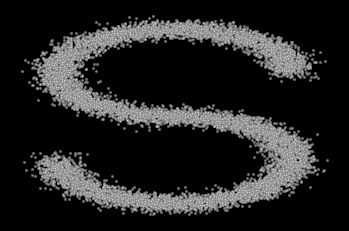

In [ ]:
# code from: https://github.com/azad-academy/denoising-diffusion-model 

import numpy as np
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
import torch
from utils import * 

# create S curve
s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

data = s_curve.T

# plot the S curve
hdr_plot_style()
plt.scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5)
plt.axis('off')

dataset = torch.Tensor(data.T).float()

In [ ]:
num_steps = 100

# apply a sigmoid schedule for the beta parameter
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

# substitute alphas
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [ ]:
# draw a sample at step t, given an initial image x_0 
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

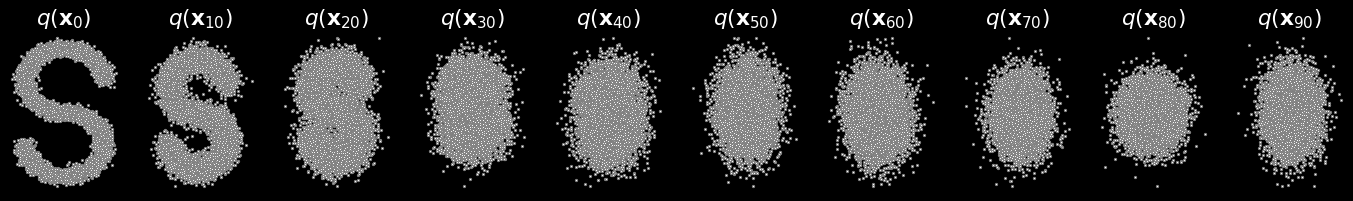

In [ ]:
# plot the samples for steps 0, 10, 20, ..., 90
fig, axs = plt.subplots(1, 10, figsize=(24, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], color='white', edgecolor='gray', s=5)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

As mentioned above, we can obtain a sample at any desired step in the forward diffusion process, by applying the level of Gaussian noise directly to the initial image. The cell below shows the image at step 15. 

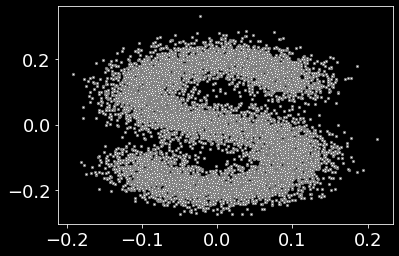

In [ ]:
# image in the 15th step
q_15 = q_x(dataset, torch.tensor([15]))
plt.scatter(q_15[:, 0], q_15[:, 1], color='white', edgecolor='gray', s=5);

<a name='section3-2'></a>

## 22.3.2 Reverse Diffusion Process

The goal of the reverse diffusion process is to denoise the images from the forward diffusion process, i.e., start with a noise imagy and obtain a clean image. Accurately calculating the reverse process $q({x}_{t-1}|{x}_{t})$ is intractable, and text-to-image models apply deep neural networks to approximate the probability density function $q({x}_{t-1}|{x}_{t})$ with a parameterized model $p_{\theta}({x}_{t-1}|{x}_{t})$, where $\theta$ denotes the parameters of the deep neural network model that are learned. The model takes as input a noisy image at step ${x}_{t-1}$ and predicts the mean and the variance of a denoised image ${x}_{t}$. 

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/reverse-diffusion.png' width=700px/>





### Example of Reverse Diffusion

The reverse diffusion process for the image S from the above example is presented below. The model is trained for 1,000 iterations, and the denoising images at steps 0, 250, 500, 750, and 1,000 are shown in the figure below. In the last row of images, we can see that the model begins with a noisy image on the left and it ends with a denoised image on the right. 

In [ ]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

The U-Net model is imported in the next cell, and the model is trained for 1,000 iterations.

Iteration: 0
Iteration: 250
Iteration: 500
Iteration: 750
Iteration: 999


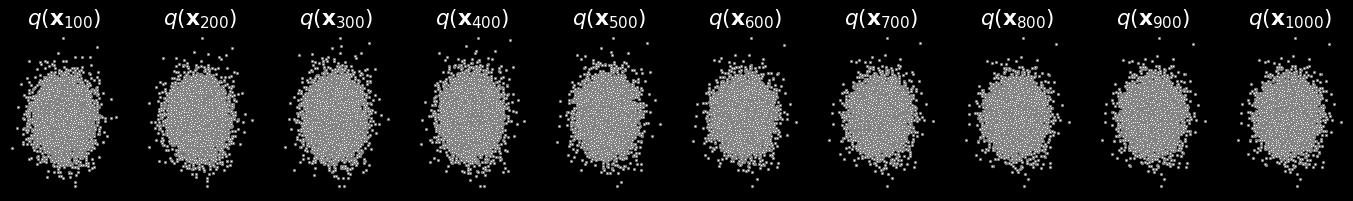

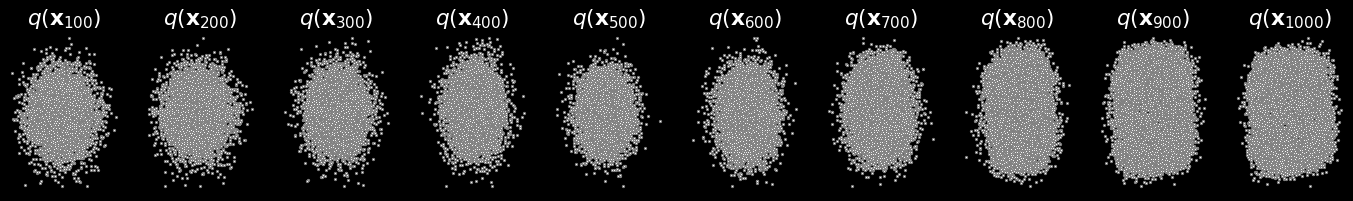

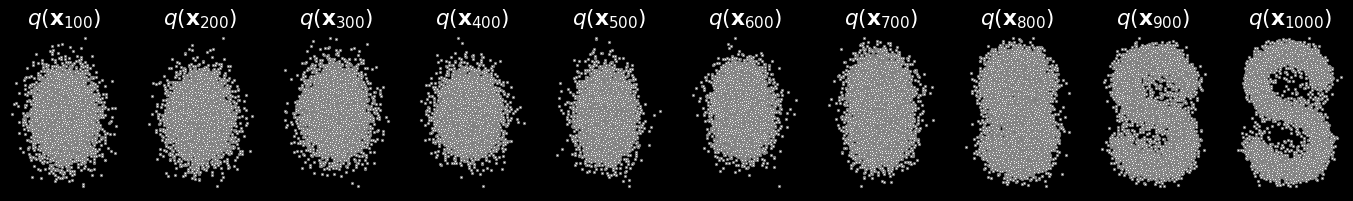

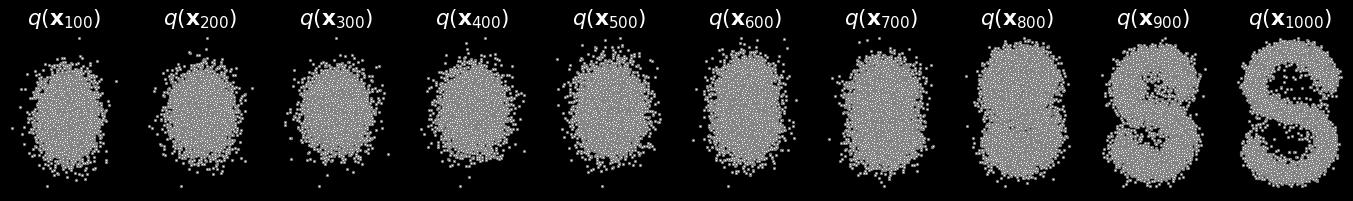

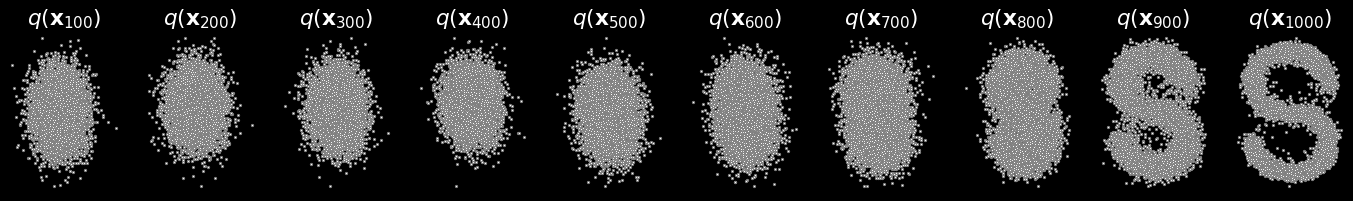

In [ ]:
from model import ConditionalModel
from ema import EMA
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128

# training
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 250==0) or (t==999):
        print('Iteration:', t)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(24, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')    

The gif image of the reverse diffusion process is shown below.

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/diffusion_S.gif' width=500px/>

### U-Net Model for Reverse Diffusion

A U-Net model is used for the reverse diffusion phase. ***U-Net*** is a popular deep learning network for image segmentation. The name is due to the architecture that looks like the letter U. It includes an encoder sub-network that extracts lower-dimensional representations, and a decoder sub-network that reconstructs the representations to full size images. I.e., the encoder first downsamples the input image (reducing its size), and afterward the decoder upsamples the representations to the size of the original image. When U-Net is used for image segmentation, the inputs are images, and the outputs are segmentation masks that segment the objects in the input images. 

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/unet.png' width=600px/>

In diffusion models, inputs to U-Net are noisy images at a particular time step for the forward diffusion process, and ouputs are the denoised images from the previous step. The model starts from the step $T$, and at each step it createas a slighly less denoised image $f{x}_{t-1 }$, until the step $0$.

<a name='section4'></a>

# 22.4 Text Encoder

To generate images based on a text prompt, text-2-image models employ text embeddings from a Language Model. In particular, the model CLIP has been used by several of these models. 

CLIP employs a Transformer Network architecure, and it was trained on a dataset of images and image captions. 

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/images-and-captions-dataset.png' width=800px/>

CLIP has a text encoder and image encoder sub-networks, and the model is designed to match text in image captions to images. During training, the model creates text and image embeddings, and learns to group together text and image embeddings that correspond to the same object. By repeating the training over a large dataset of images and image captions, the model produce an embeddings space of matched text and images for a large number of objects. 

<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/clip-training.png' width=800px/>

<a name='section5'></a>

# 22.5 Latent Diffusion Models

***Latent Diffusion Models*** apply the diffusion process to a compressed image representation in a lower-dimensional space, instead of applying the diffusion process to the raw high-dimensional images. The lower-dimensional space is called *latent space*, hence the name for these models. The key advantage of Latent Diffusion Models is computational efficiency, due to processing small-size image representations. For instance, Stable Diffusion is trained on images of size 512x512 pixels, whereas the size of the image representations in the latent space is 64x64 pixels. Other advantages of performing the diffusion process in the latent space instead in pixel space is producing diverse images that preserve the semantic structure of the data. 

An annotated figure of a Latent Diffusion Model is shown in the next figure. The components of the model are described next. 


<img src='https://raw.githubusercontent.com/avakanski/Fall-2022-Python-Programming-for-Data-Science/main/Lectures/Theme%203%20-%20Model%20Engineering%20Pipelines/Lecture%2022%20-%20Diffusion%20Models/images/latent_diffusion_model.png' width=800px/>




### Perceptual Compression

The input image to the model is shown in the upper left corner. The input image is in the Pixel Space, i.e., it consists of raw pixels. During the perceptual compression step, teh image is projected into latent space. For this step, an Encoder network is employed to produce a lower-dimensional representation of the input image. 

### Forward Diffusion Step

Forward diffusion process is applied to the latent representation of the image, by applying steps of gradually corrupting the image with Gaussian noise. 

### Semantic Compression

This steps corresponds to the right-hand block in the figure, and typically refers to using a language model to capture the semantic structure in text and images. One example is the Text/Image transformer CLIP model from the previous section, which is used to guide the image generation process by providing a compressed represetation of text and image embeddings. The compressed representation is denoted $\tau_{\theta}$ in the figure. 

Reverse Diffusion Step

The reverse diffusion step takes noisy images and gradualy removes the noise to generate clean images. As we mentioned, a denoising U-Net network is employed for learning the denoising process. The reverse diffusion process is conditioned on the text/image representation from the pretrained CLIP transformer model, i.e., this model guides the denoising process by mapping the compressed text/image representations to the intermediate layers of the U-Net via cross-atention layers. The cross-attention layers are similar to self-attention mechanism in transformer networks, and they learn a set of Q (querries), K (keys) , and V (values) matrices. 






### Generated Images

The obtained latent vector is passed through another decoder to increase the resolution back to the size of original image. The resulting representations in the latent space are 64x64 pixels, and the decoder recovers the image back to 512x512 pixels. 

<a name='section10'></a>

# References

1. High-performance image generation using Stable Diffusion in KerasCV, available at [https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).
2. Diffusion Models Made Easy, J. Rafid Siddiqui, available at [https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da](https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da).
3. How Diffusion Models Work: The Math From Scratch, available at [https://theaisummer.com/diffusion-models/](https://theaisummer.com/diffusion-models/).
4. The Illustrated Stable Diffusion, Jay Alammar, avaiable at [https://jalammar.github.io/illustrated-stable-diffusion/](https://jalammar.github.io/illustrated-stable-diffusion/).
5. What are Stable Diffusion Models and Why are they a Step Forward for Image Generation?, J. Rafid Siddiqui, available at [https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46](https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46).

[BACK TO TOP](#section0)